In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

In [2]:
tf.__version__

'1.4.0'

In [3]:
from lib.tfmodels import vgg16

vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
def gray_to_rgb(image):
    w, h = image.shape
    res = np.empty((w, h, 3), dtype=np.uint8)
    res[:, :, 0] = image
    res[:, :, 1] = image
    res[:, :, 2] = image
    return res

def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = np.asarray(image.resize(size, PIL.Image.LANCZOS), dtype=np.float32)

        if len(image.shape) == 2:
            image = gray_to_rgb(image)

    # Convert to numpy floating-point array.
    return image

In [5]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

In [6]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

In [7]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [9]:
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)
            
        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [10]:
def gram_matrix(tensor):
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

In [11]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
        
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [12]:
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [13]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image.
    gradient = tf.gradients(loss_combined, model.input)
    
    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [14]:
content_filename = 'images/heightmap.jpg'
content_image = load_image(content_filename, max_size=300)

In [15]:
style_filename = 'images/landscape.jpg'
style_image = load_image(style_filename, max_size=300)

In [16]:
content_layer_ids = [4]

In [17]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = [0, 2, 4, 7, 10]

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv2_1/conv2_1', 'conv3_1/conv3_1', 'conv4_1/conv4_1', 'conv5_1/conv5_1']

. 
Iteration: 0
Weight Adj. for Content: 8.60e-11, Style: 2.49e-28, Denoise: 5.57e-06


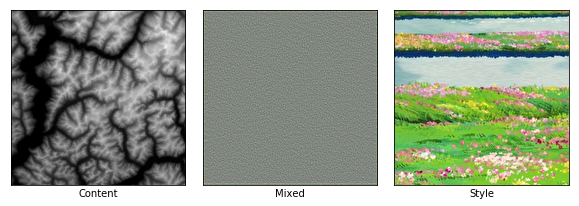

. . . . . . . . . 
Iteration: 9
Weight Adj. for Content: 8.56e-11, Style: 1.72e-27, Denoise: 1.32e-07


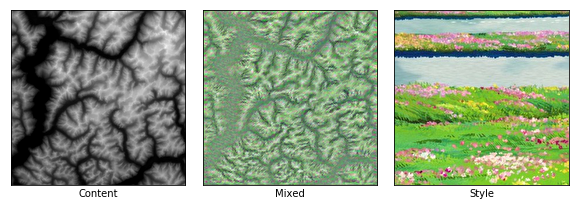


Final image:


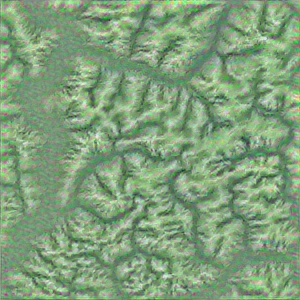

CPU times: user 1min 47s, sys: 12.3 s, total: 1min 59s
Wall time: 26.6 s


In [18]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=8.0,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=10,
                     step_size=10.0)

In [27]:

import vispy as vp
from vispy import app
vp.use(app='ipynb_webgl', gl="gl+")
gloo = vp.gloo


RuntimeError: Could not import gl target "webgl":
No module named 'vispy.gloo.gl.webgl'

In [20]:
#Generate Vertices

content_image_g = content_image[:, :, 0]
content_image_g = np.squeeze(content_image_g)
content_image_map = np.ndenumerate(content_image_g)
vertices = [position + (value,) for position,value in content_image_map]
vertices = np.array(list(map(list, vertices))).astype(np.float32)
print(vertices)

[[   0.    0.  105.]
 [   0.    1.  106.]
 [   0.    2.   97.]
 ..., 
 [ 299.  297.  114.]
 [ 299.  298.  107.]
 [ 299.  299.   90.]]


In [21]:
from scipy.spatial import Delaunay

In [22]:
# note to self may need to include projection matrix later
VERT_SHADER = """
uniform vec3 u_centerPosition;

uniform mat4 projectionMatrix; 
uniform mat4 modelMatrix;
uniform mat4 u_view;
attribute vec3 position;
varying vec2 v_textureCoord;

void main () {
    gl_Position  = projectionMatrix *  u_view * modelMatrix * vec4(position,1.0f);
    v_textureCoord = position.xy;
    
}
"""

# Deliberately add precision qualifiers to test automatic GLSL code conversion
FRAG_SHADER = """
varying vec2 v_textureCoord;
uniform sampler2D s_texture;
void main()
{
    vec4 texColor;
    texColor = texture2D(s_texture, v_textureCoord * 0.00332f);
    if (texColor.rgb == vec3(1.0,1.0,1.0))
      texColor = vec4(v_textureCoord/300.0f, 1.0, 1.0);
    
    gl_FragColor = texColor;
}
"""


def lookat(M, camera, look):
    """Computes matrix to put camera looking at look point."""
    c = np.asarray(camera).astype(float)

    # u, v, w are the new axis directions. Since OpenGL has the camera view in
    # the negative z direction, w is the vector from the lookat point to the
    # camera position.
    w = c - np.asarray(look).astype(float)

    # To get u, we just cross the "up" direction (same as old up direction)
    # with our new w.
    u = np.cross([0, 1, 0], w)

    # Finally, we can recover our new, orthogonal up direction by crossing w
    # and u.
    v = np.cross(w, u)

    # Take the norm of each vector.
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    w /= np.linalg.norm(w)

    # This vector is a translation followed by a rotation. A vector is
    # translated by negative c, which means that vector is moved to its camera
    # position. Then, the rotation from the new coordinates is applied.
    T = np.r_[u, u.dot(-c),
              v, v.dot(-c),
              w, w.dot(-c),
              0, 0, 0, 1].reshape(4, 4)
    M[...] = T.dot(M)
    return M

class Canvas(app.Canvas):

    def __init__(self):
        app.Canvas.__init__(self, keys='interactive')
        self.program = gloo.Program(VERT_SHADER, FRAG_SHADER)
        shape = (300, 300)
        print(style_image.shape)
        self.view = np.eye(4)
        self.program['u_view'] = self.view;
        #positions = np.zeros(90000, [('position', np.float32, 3)])
        #self.program.bind(gloo.VertexBuffer(positions))
        tex = gloo.Texture2D(data =img.astype('float32')/255.0);
        tex.interpolation = 'linear'
        self.program['s_texture'] = tex
        tri = Delaunay(vertices)
        #print(vertices[tri.simplices])
        #print("test")
        self.program['position'] = gloo.VertexBuffer(np.vstack(vertices[tri.simplices]))
        
        self.program['modelMatrix'] = np.dot(np.eye(4), vp.util.transforms.translate([-1* style_image.shape[0] * 0.5, -1 * style_image.shape[0] * 0.5, -1 * style_image.shape[0] * 2]))
        
        self.activate_zoom()

        gloo.set_state(clear_color='black', depth_test=True)

        self.show()

    def on_resize(self, event):
        self.activate_zoom()

    def activate_zoom(self):
        gloo.set_viewport(0, 0, *self.physical_size)
        print(self.physical_size)
        print(self.size)
        self.program['projectionMatrix'] = vp.util.transforms.perspective(45.0, self.size[0]/float(self.size[1]), 1.0, 1000.0);

    def on_key_press(self, event):
        """Controls -
        a(A) - move left
        d(D) - move right
        w(W) - move up
        s(S) - move down
        x/X - rotate about x-axis cw/anti-cw
        y/Y - rotate about y-axis cw/anti-cw
        z/Z - rotate about z-axis cw/anti-cw
        space - reset view
        p(P) - print current view
        i(I) - zoom in
        o(O) - zoom out
        """
        print("key press happened")
        self.view = np.dot(self.view, vp.util.transforms.rotate(-1, (1, 0, 0)))
        print (self.view.shape);
        self.program['u_view'] = self.view
        self.update()
    
    def on_draw(self, event):
        # Clear
        gloo.clear(color=True, depth=True)
        # Draw
        
        print (self.view.shape);
        self.program['u_view'] = self.view
        self.program.draw('triangles')
        self.update()


canv = Canvas()
canv.show()
app.run();


(300, 300, 3)
(800, 600)
(800, 600)
(800, 600)
(800, 600)
(4, 4)
